# Interactive runner of SAYNT project

This interactive runner should be used for running (S)PAYNT, reinforcement learning sub-project and figure plotter.

Import TensorFlow and PAYNT related stuff.

In [237]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tf_agents
import sys


## Run reinforcement learning

Example of how to run reinforcement learning project with custom arguments.

In [238]:
sys.path.append("rl_src")
from rl_src.experiment_runner import run_single_experiment
from rl_src.tools.args_emulator import ArgsEmulator

In [239]:
name_of_experiment = "test_jupyter" # Name of the experiment, there will be stored experiment results.

prism_model = "rl_src/models/evade/sketch.templ"
prism_properties = "rl_src/models/evade/sketch.props"

learning_rate = 0.00016
batch_size = 256
num_environments = batch_size
randomized_starts = False

learning_method = "Stochastic_PPO"
agent_name = "evade"

run_rl = False

In [240]:

args = ArgsEmulator(
    prism_model=prism_model, prism_properties=prism_properties, learning_rate=learning_rate,
    restart_weights=0, learning_method=learning_method, evaluation_episodes=30,
    nr_runs=10, agent_name=agent_name, load_agent=False,
    evaluate_random_policy=False, max_steps=400, evaluation_goal=50, evaluation_antigoal=-20,
    trajectory_num_steps=32, discount_factor=0.99, num_environments=num_environments,
    normalize_simulator_rewards=False, buffer_size=500, random_start_simulator=randomized_starts,
    batch_size=batch_size, vectorized_envs_flag=True, flag_illegal_action_penalty=False
)

if run_rl:
    run_single_experiment(args, model=args.agent_name, name_of_experiment=name_of_experiment, learning_method=learning_method, save_statistics=True)

## Plot Figures

Plot figures from experimental evaluation.

First, we include some important libraries.

In [241]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

import os

In [242]:
class PreviousStats:
    """Class for storing previous statistics."""

    def __init__(self, best_return_spaynt=None, best_reach_probs_spaynt=None, best_return_rl=None,
                 best_reach_probs_rl=None, best_return_unstable=None, best_reach_probs_unstable=None,
                 best_reach_probs_paynt=None):
        self.best_return_spaynt = best_return_spaynt
        self.best_reach_probs_spaynt = best_reach_probs_spaynt
        self.best_return_rl = best_return_rl
        self.best_reach_probs_rl = best_reach_probs_rl
        self.best_return_unstable = best_return_unstable
        self.best_reach_probs_unstable = best_reach_probs_unstable
        self.best_reach_probs_paynt = best_reach_probs_paynt

DICT_OF_PREV_STATS = {
    "drone-2-8-1": PreviousStats(None, 0.4, None, 0.0),
    "evade": PreviousStats(-24.999, 1.0, None, 0.698, None, 1.0),
    "evade-n=5-r=23": PreviousStats(-17.0, 1.0, -20.600, 1.0, -16.095),
    "evade-n6-r2": PreviousStats(-21.0, 1.0, -28.0, 1.0, None, None),
    "grid-large-10-5": PreviousStats(-38.719, 1.0, -36.65, 1.0, None, None),
    "grid-large-30-5": PreviousStats(None, None, None, 1.0),
    "intercept": PreviousStats(-15.060, 1.0, -13.45, 1.0, None, None),
    "intercept-n7-r1": PreviousStats(-15.453, 1.0, -16.9, 1.0),
    "mba": PreviousStats(-6.265, 1.0, -5.5, 1.0, None, None),
    "mba-small": PreviousStats(-4.598, 1.0, -3.45, 1.0),
    "network-3-8-20": PreviousStats(-11.284, 1.0, -8.399, 1.0, -3.231, 1.0),
    "obstacle": PreviousStats(-4.2825, 1.0, -34.9, 1.0),
    "obstacles-uniform": PreviousStats(-14.758, 1.0, -49.55, 1.0),
    "refuel-10": PreviousStats(None, 0.457, None, 0.2, None, 0.375),
    "refuel-20": PreviousStats(None, 0.296, None, 0.0, None, 0.3),
    "rocks-16": PreviousStats(-36.911, 1.0, -32.5, 1.0),
    "super-intercept": PreviousStats(None, 0.848, None, 0.85),
    "geo-2-8": PreviousStats(None, 0.616, None, 0.8),
    "network-5-10-8": PreviousStats(-16.050, 1.0, -13.0, 1.0, -10.898, 1.0),
    "rocks-4-20": PreviousStats(-76.0, 1.0, -75.9, 1.0),
    "geo-2-8-large": PreviousStats(None, 0.124, None, None),
    "obstacle-large": PreviousStats(25.78, 1.0),
    "intercept-large": PreviousStats(None, 0.78),
    "evade-large": PreviousStats(None, 0.0),
    "maze-10": PreviousStats(8.5093, 1.0, 4.059, 1.0, 2.30, 1.0),
    "maze-10-rewarded": PreviousStats(85.093, 1.0, 40.59, 1.0, 23.0, 1.0),
    "avoid": PreviousStats(),
    "evade-n12": PreviousStats(None, 0.61, None, 0.0)
}

Second, we load all files from experiment folders.

In [243]:
def load_all_results_from_jsons(experiment_folder):
    all_files = os.listdir(experiment_folder)
    all_results = {}
    for file in all_files:
        if file.endswith(".json"):
            path = os.path.join(experiment_folder, file)
            with open(path) as f:
                if "evade-n12" in file:
                    file = file.replace("evade-n12", "evade-n16")
                all_results[file] = json.load(f)
    return all_results

def load_all_pickle_fscs(experiment_folder):
    import pickle as pkl
    all_files = os.listdir(experiment_folder)
    all_results = {}
    for file in all_files:
        if file.endswith(".pkl"):
            path = os.path.join(experiment_folder, file)
            with open(path, "rb") as f:
                all_results[file] = pkl.load(f)
    return all_results

def init_merged_result_dict():
    return {
        "returns_episodic": [],
        "returns": [],
        "reach_probs": [],
        "trap_reach_probs": [],
        "losses": [],
        "each_episode_variance": [],
        "each_episode_virtual_variance": [],
        "combined_variance": [],
        "paynt_bounds" : [],
        "extracted_fsc_return" : [],
        "extracted_fsc_reach_prob" : [],
    }

def init_fsc_result_dict():
    return {
        "observation_to_action_table": [],
        "observation_to_update_table": [],
        "percentage_of_misses": [],
    }


def merge_multiple_runs(all_results, dict_initializer):
    """Merges result of multiple runs over each single model into a single dictionary of models."""
    merged_results = {}
    for file in all_results:
        model_name = file.split("_")[0]

        if model_name not in merged_results:
            merged_results[model_name] = dict_initializer()
        for key in merged_results[model_name]:
            if key == "extracted_fsc_return" or key == "extracted_fsc_reach_prob":
                if float(all_results[file][key]) == -1.0:
                    # print(f"Model {model_name} key {key} has -1 value")
                    continue
            data = all_results[file][key]
            if isinstance(data, str):
                data = json.loads(data)
            merged_results[model_name][key].append(np.array(data).astype(np.float32))
    return merged_results

Load and merge results into a single dictionary.

In [244]:
experiment_folders_imitation = {"Original Batch Size 256 LR 0.00016": "rl_src/experiments_payntless/experiments_0.00016_256/",
                      "Original Randomized Size 256 LR 0.00016": "rl_src/experiments_payntless_random/experiments_0.00016_256/",
                      "Behavioral Cloning": "PAYNT_BehavioralCloning",
                      "JumpStarts": "PAYNT_JumpStart",
                      "PAYNT Reward Shaping": "PAYNT_Shaping",
                      "Weaker PAYNT Policy Cloning": "rl_src/experiments_various_fixed/enchanced_refuels/bc_0.00016_256/",
                      "BC Longer Trajectories": "PAYNT_BehavioralCloning_longer_trajectories/",
                      "BC Repeated Cloning": "PAYNT_BehavioralCloning_continuous_training/",
                      "Shaping Longer Period": "PAYNT_Shaping_longer/"}

experiment_folders_loop = {
    "Loop w Fixed Memory Steps, Reward Shaping, Greedy": "PAYNT_w_Advices_loop_R_Shaping_greedy",
    "Loop w Dynamic Memory Steps, Reward Shaping, Greedy": "PAYNT_w_Advices_loop_R_Shaping_w_Memory_greedy",
}

experiment_folders_memory_models = {
    "RNN Memory": "rl_src/experiments_fixed_simulator/experiments_0.00016_256/",
    "Memoryless": "rl_src/experiments_fixed_simulator_rnn_less/experiments_0.00016_256/",
    "Memory Model Size = 2": "rl_src/experiments_fixed_simulator_rnn_less_memory_2/experiments_0.00016_256/",
    "Memory Model Size = 5": "rl_src/experiments_fixed_simulator_rnn_less_memory_5/experiments_0.00016_256/",
    "Memory Model Size = 10": "rl_src/experiments_fixed_simulator_rnn_less_memory_10/experiments_0.00016_256/",
    "RNN Memory Larger": "rl_src/experiments_fixed_simulator/experiments_6.6e-05_256/",
}
experiment_folders_pure_rl = {
    "Pure RL": "rl_src/experiments_martin_tappler_without_state_est/experiments_0.0001_256/"
}

experiment_folders_rms = {
    "Pure RL with Trajectory Length 16": "rl_src/experiments_rms/experiments_16/experiments_0.00016_256/",
    # "Pure RL with Trajectory Length 32": "rl_src/experiments_rms/experiments_32/experiments_0.00016_256/",
    # "Pure RL with Trajectory Length 64": "rl_src/experiments_rms/experiments_64/experiments_0.00016_256/",
    "Go-Explore with Trajectory Length 16": "rl_src/experiments_rms/experiments_16_go_explore/experiments_0.00016_256/",
    # "Go-Explore with Trajectory Length 32": "rl_src/experiments_rms/experiments_32_go_explore/experiments_0.00016_256/",
    # "Go-Explore with Trajectory Length 64": "rl_src/experiments_rms/experiments_64_go_explore/experiments_0.00016_256/",
    "Predicate Observation with Trajectory Length 16": "rl_src/experiments_rms/experiments_16_predicate_automata_obs/experiments_0.00016_256/",
    # "Predicate Observation with Trajectory Length 32": "rl_src/experiments_rms/experiments_32_predicate_automata_obs/experiments_0.00016_256/",
    # "Predicate Observation with Trajectory Length 64": "rl_src/experiments_rms/experiments_64_predicate_automata_obs/experiments_0.00016_256/",
    "Curiosity Reward with Trajectory Length 16": "rl_src/experiments_rms/experiments_16_curiosity_automata_reward/experiments_0.00016_256/",
    # "Curiosity Reward with Trajectory Length 32": "rl_src/experiments_rms/experiments_32_curiosity_automata_reward/experiments_0.00016_256/",
    # "Curiosity Reward with Trajectory Length 64": "rl_src/experiments_rms/experiments_64_curiosity_automata_reward/experiments_0.00016_256/",


}

experiment_entropy = {
    "Original" : "rl_src/experiments_entropy_training/entropy/experiments_0.00016_256/",
    "Entropy partial observability": "rl_src/experiments_entropy_training/entropy_e/experiments_0.00016_256/",
    "Entropy full observability": "rl_src/experiments_entropy_training/entropy_e_fo/experiments_0.00016_256/",
    "Binary Entropy with partial observability": "rl_src/experiments_entropy_training/entropy_e_be/experiments_0.00016_256/",
    "Binary Entropy with full observability": "rl_src/experiments_entropy_training/entropy_e_fo_be/experiments_0.00016_256/",
}

experiment_folders_drone = {
    "Pure RL with Trajectory Length 32": "rl_src/experiments_drone_only/experiments_0.00016_256/",}

experiment_folders = experiment_folders_rms


experiment_names = list(experiment_folders.keys())
experiment_results = {name: load_all_results_from_jsons(experiment_folders[name]) for name in experiment_names}

merged_results = {name: merge_multiple_runs(experiment_results[name], init_merged_result_dict) for name in experiment_names}
fscs = {name: load_all_pickle_fscs(experiment_folders[name]) for name in experiment_names}
merged_fscs = {name: merge_multiple_runs(fscs[name], init_fsc_result_dict) for name in experiment_names}


Summarize results to provide data for IQR plots.

In [245]:

def get_previous_optimum_constant(name, metric):
    if name in DICT_OF_PREV_STATS:
        if metric == "returns":
            return DICT_OF_PREV_STATS[name].best_return_spaynt
        elif metric == "reach_probs":
            
            return DICT_OF_PREV_STATS[name].best_reach_probs_spaynt

PAYNT_OPTIMAS = {
    "evade": 0.932,
    "geo-2-8": 0.569,
    "intercept-n7-r1": None,
    "intercept": 0.931,
    "network-3-8-20": -11.070,
    "network-5-10-8": -41.026,
    "refuel-10": 0.180,
    "refuel-20": 0.243,
    "rocks-16": -46.0,
    "intercept-large": None,
    "drone-2-8-1": 0.0,
    "maze-10" : 4.059,
    "maze-10-rewarded" : 1.0 # 40.59,
}
def get_paynt_default_optimum(name, metric):
    if name in PAYNT_OPTIMAS:
        return PAYNT_OPTIMAS[name]
    return None


def plot_results_for_single_experiment_with_metric(pdf, metric, model_name, save_fig=False, save_path=None):
    """Summarizes results for a single model."""
    plt.figure(figsize=(10, 5))
    plt.rcParams.update({'font.size': 13})  # Zvýší velikost fontu v celém grafu

    color_cycle = iter(plt.rcParams['axes.prop_cycle'])

    for key in pdf:
        steps = np.arange(len(pdf[key]["mean"]))
        color = next(color_cycle)['color']

        sns.lineplot(x=steps, y=pdf[key]["mean"], label=key, color=color)
        plt.fill_between(steps, pdf[key]["q1"], pdf[key]["q3"], alpha=0.5, color=color)
        sns.lineplot(x=steps, y=pdf[key]["min"], linestyle='--', alpha=0.5, color=color)
        sns.lineplot(x=steps, y=pdf[key]["max"], linestyle='--', alpha=0.5, color=color)

        if "extracted_fsc_return_mean" in pdf[key]:
            plt.scatter(steps[-1], pdf[key]["extracted_fsc_return_mean"], color=color, marker='o', s=100)
        if "extracted_fsc_reach_prob_mean" in pdf[key]:
            plt.scatter(steps[-1], pdf[key]["extracted_fsc_reach_prob_mean"], color=color, marker='x', s=100)
        try:
            for value, iteration in pdf[key]["paynt_bounds"]:
                plt.scatter(iteration, value, color=color, marker='x', s=100)
        except Exception as e:
            print(f"Error in plotting PAYNT bounds: {e}")

    found_optimum = get_previous_optimum_constant(model_name, metric)
    if found_optimum is not None:
        plt.axhline(y=found_optimum, color='r', linestyle='--', label="SPAYNT Optimum")
    initial_optimum = get_paynt_default_optimum(model_name, metric)
    if initial_optimum is not None:
        plt.axhline(y=initial_optimum, color='g', linestyle='--', label="PAYNT Optimum (from SAYNT loop)")

    plt.title(f"{metric} over time, model: {model_name}", fontsize=15)
    plt.xlabel("i-th 50 iteration", fontsize=13)
    plt.ylabel(metric, fontsize=13)
    plt.legend(fontsize=11)

    plt.tight_layout(pad=1.0)  # Odstraní přebytečné bílé okraje kolem grafu

    if save_fig:
        path, _ = os.path.split(save_path)
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(save_path, bbox_inches='tight')  # Ořeže bílý prostor při ukládání
    else:
        plt.show()

In [246]:
def plot_results_for_single_model(merged_results, model_name, metric, save_fig=False, save_path=None):
    metric_data = {}
    for experiment_name in merged_results:
        # plot_results_for_single_experiment_with_metric(merged_results[experiment_name][model_name], "returns")
        if model_name not in merged_results[experiment_name]:
            continue

        metric_data[experiment_name] = {}
        # print(merged_results[experiment_name][model_name][metric])
        minimal_length = 4000000
        for result in merged_results[experiment_name][model_name][metric]:
            if result.shape[0] < minimal_length:
                minimal_length = result.shape[0]
        for i, result in enumerate(merged_results[experiment_name][model_name][metric]):
            if result.shape[0] > minimal_length:
                merged_results[experiment_name][model_name][metric][i] = result[:minimal_length]
        merged_sub_results = np.array(merged_results[experiment_name][model_name][metric])
        
        metric_data[experiment_name]["mean"] = np.mean(merged_sub_results, axis=0)
        metric_data[experiment_name]["q1"] = np.quantile(merged_sub_results, 0.25, axis=0)
            
        metric_data[experiment_name]["q3"] = np.quantile(merged_sub_results, 0.75, axis=0)
        metric_data[experiment_name]["min"] = np.min(merged_sub_results, axis=0)
        metric_data[experiment_name]["max"] = np.max(merged_sub_results, axis=0)
        if not len(merged_results[experiment_name][model_name]["extracted_fsc_return"]) == 0:
            
            if metric == "returns":
                metric_data[experiment_name]["extracted_fsc_return_mean"] = np.mean(merged_results[experiment_name][model_name]["extracted_fsc_return"])
                metric_data[experiment_name]["extracted_fsc_return_std"] = np.std(merged_results[experiment_name][model_name]["extracted_fsc_return"])
            elif metric == "reach_probs":
                metric_data[experiment_name]["extracted_fsc_reach_prob_mean"] = np.mean(merged_results[experiment_name][model_name]["extracted_fsc_reach_prob"])
                metric_data[experiment_name]["extracted_fsc_reach_prob_std"] = np.std(merged_results[experiment_name][model_name]["extracted_fsc_reach_prob"])
    pdf = pd.DataFrame(metric_data)
    plot_results_for_single_experiment_with_metric(pdf, metric, model_name, save_fig=save_fig, save_path=save_path)
    


/tmp/ipykernel_235342/206526375.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=11)


Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'


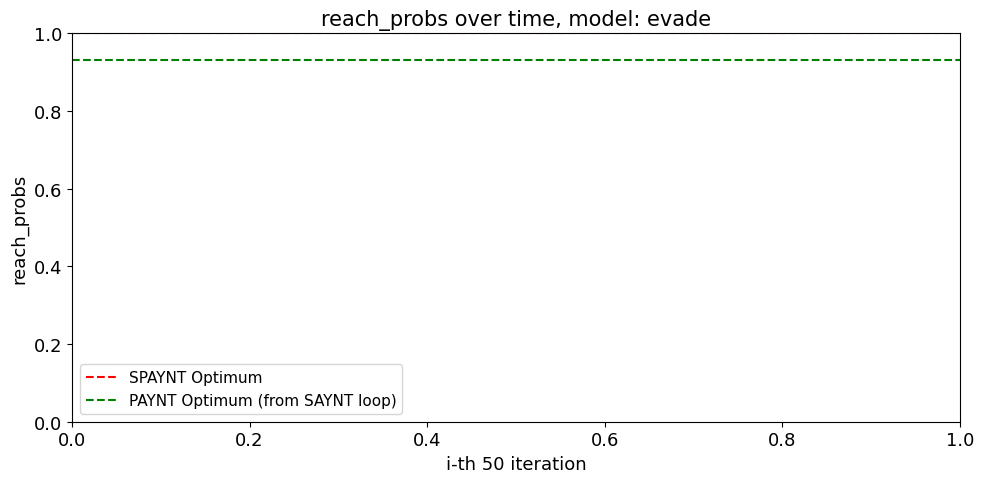

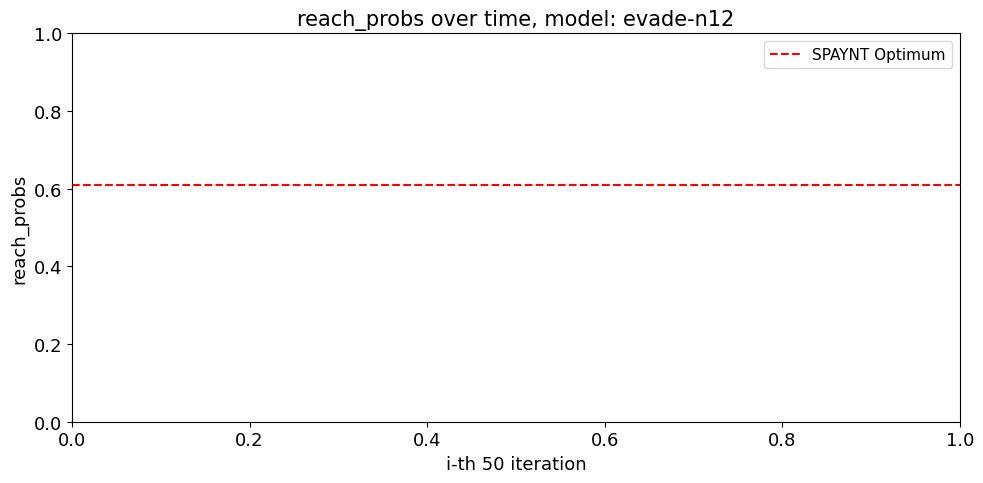

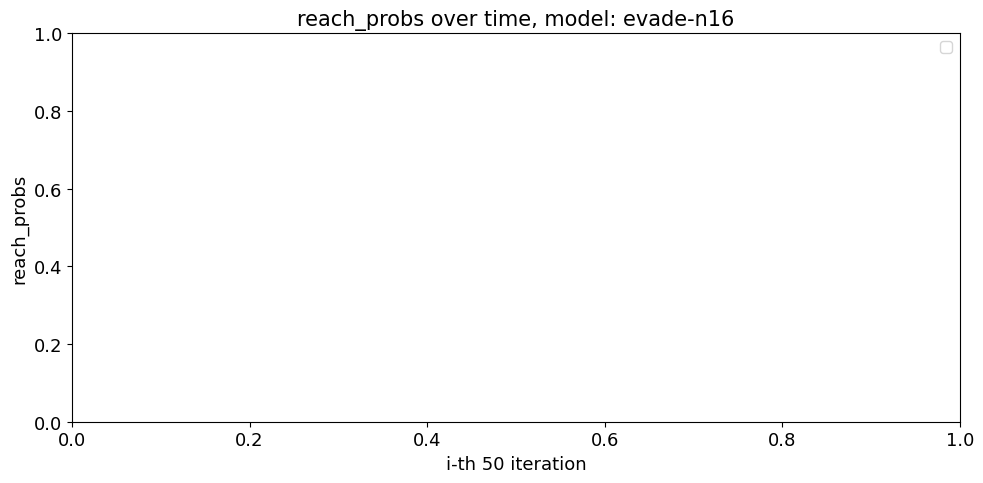

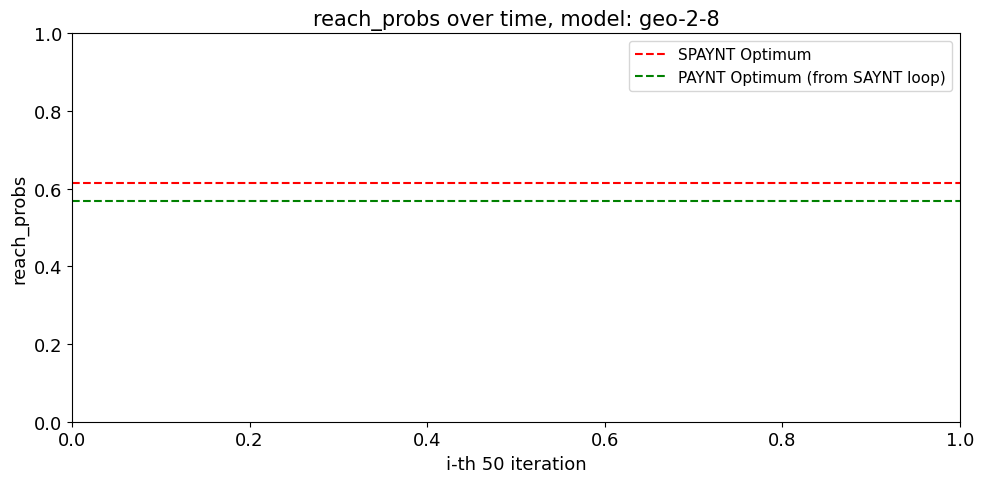

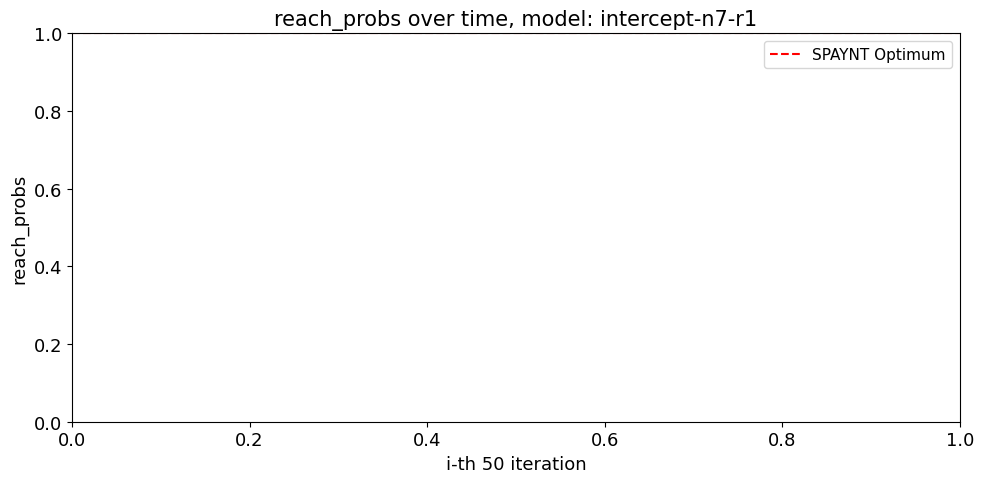

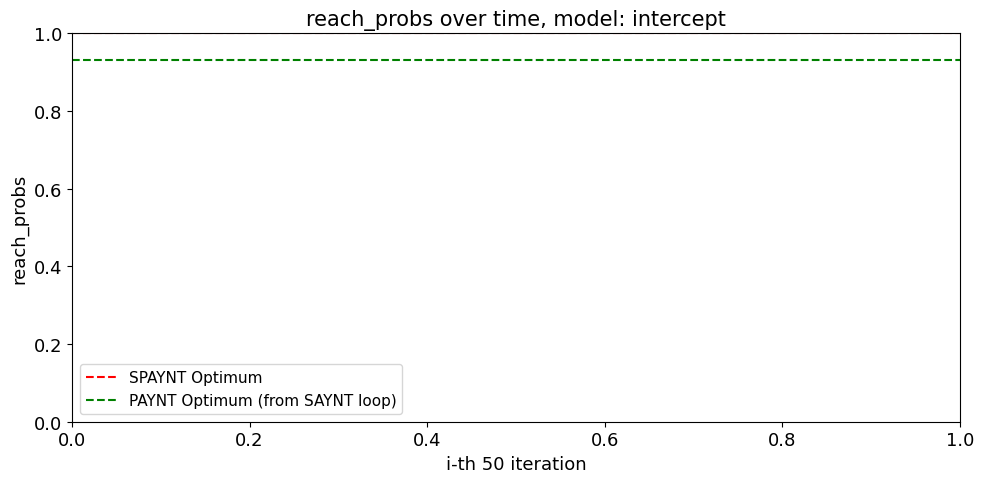

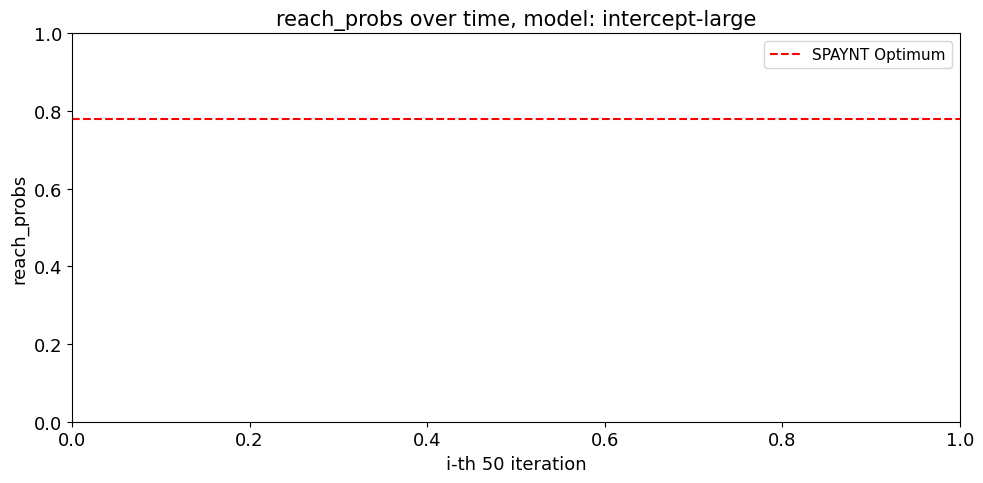

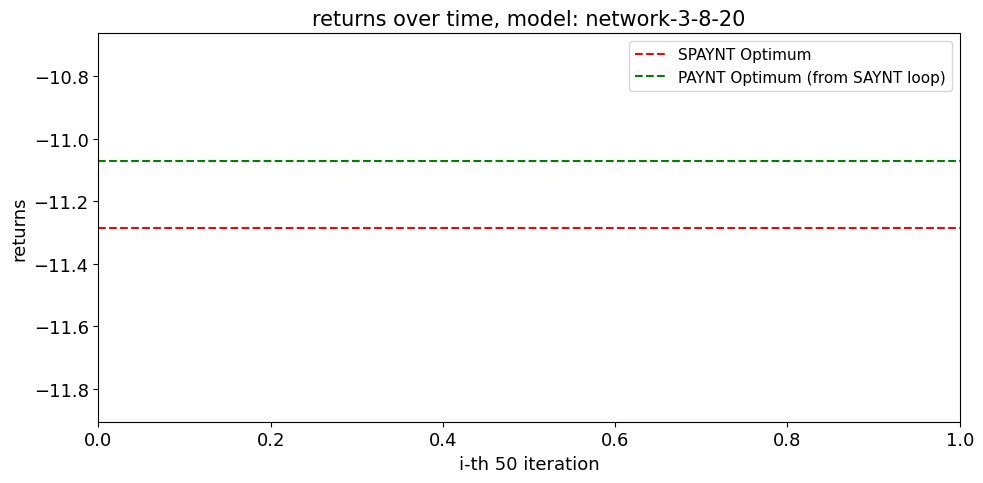

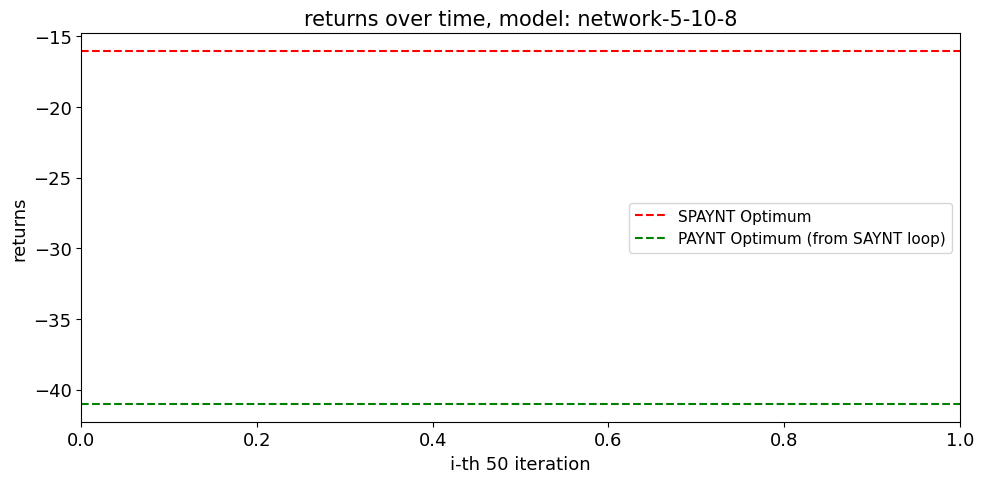

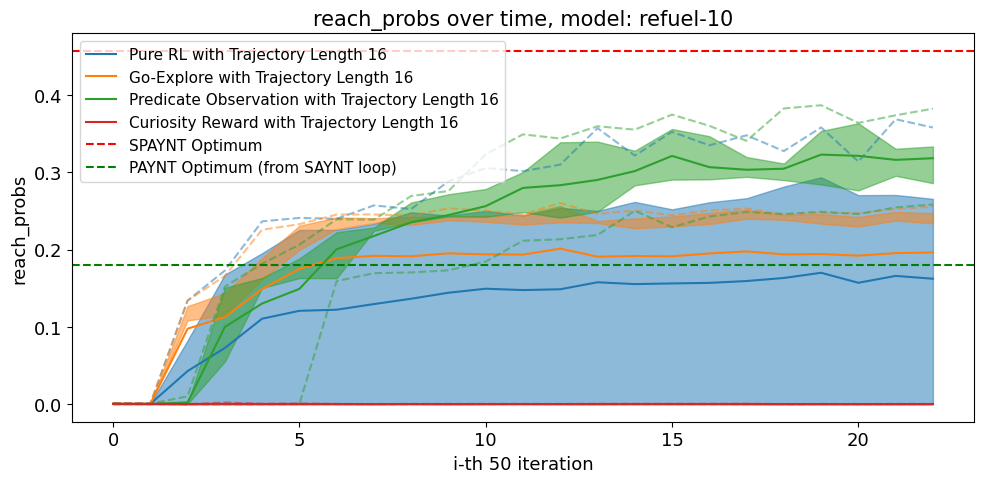

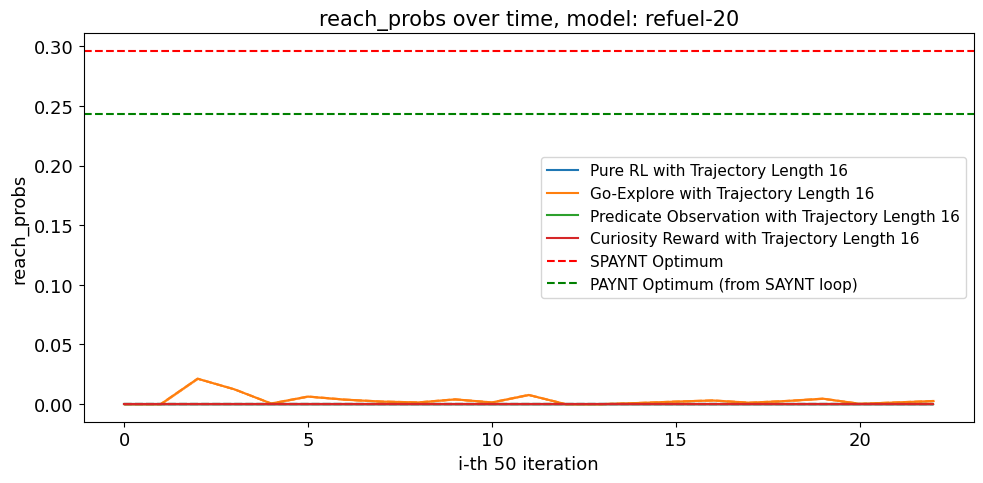

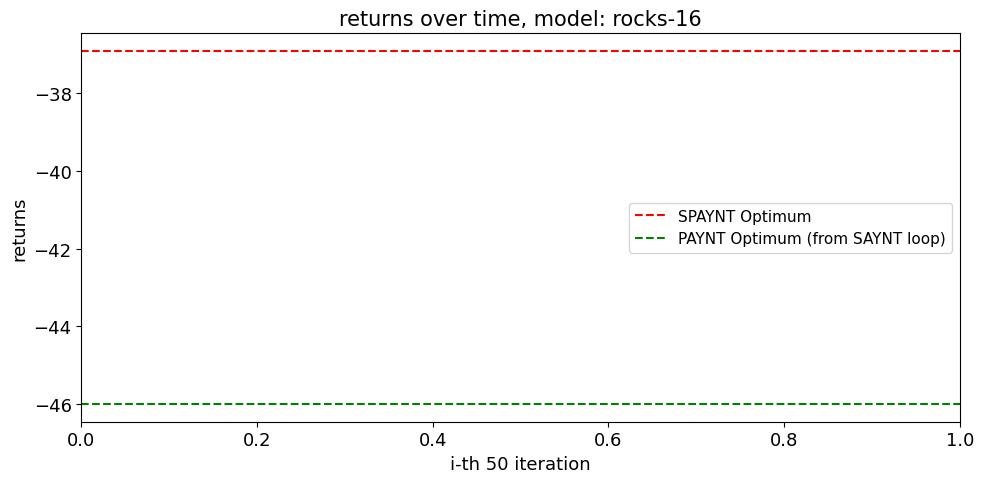

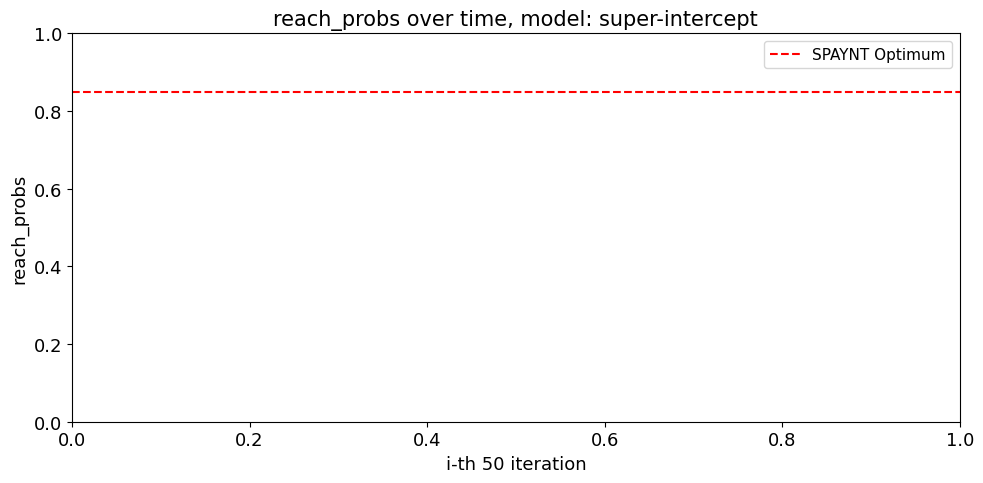

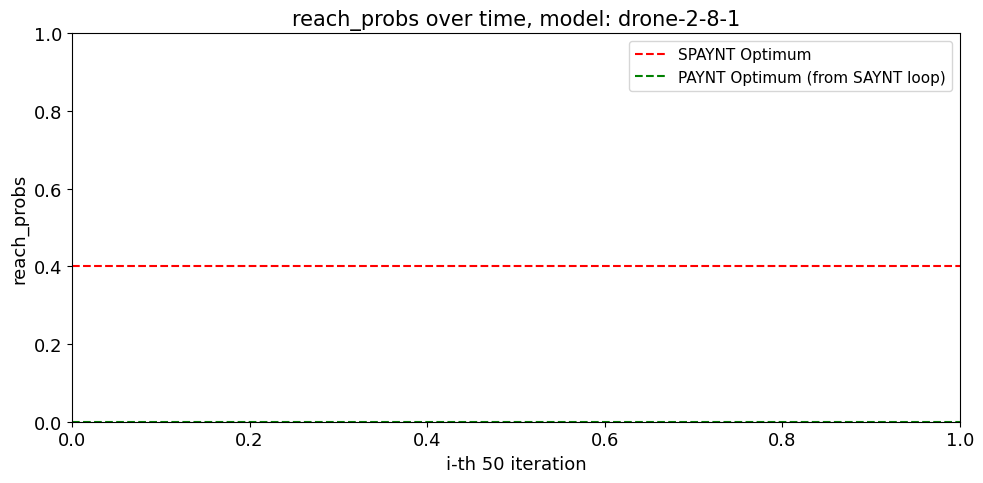

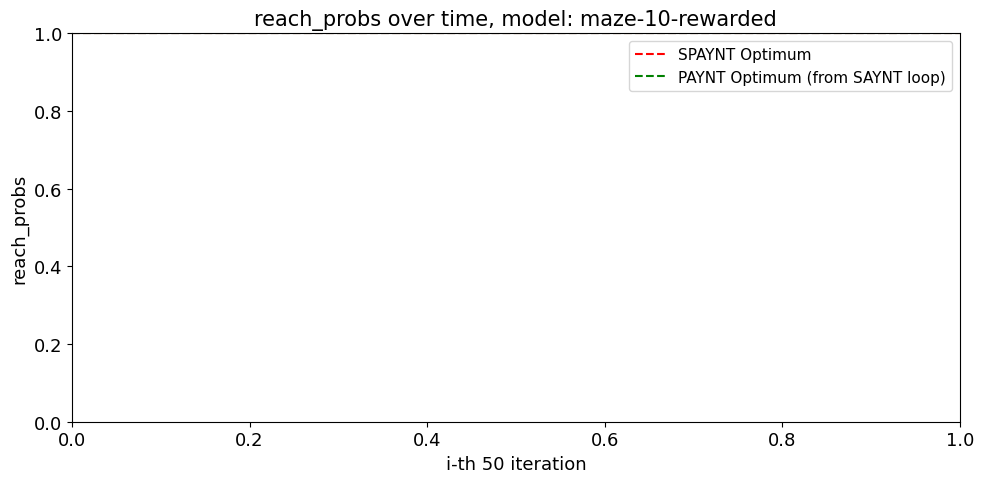

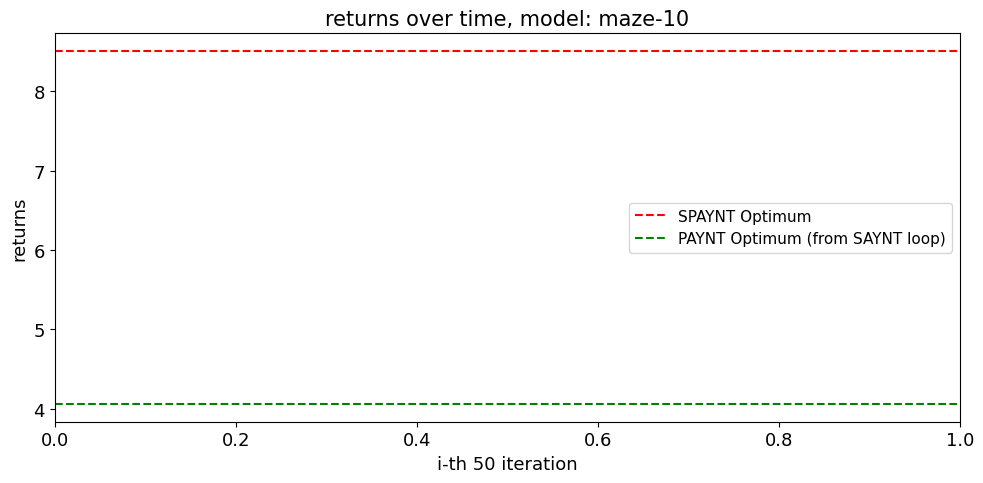

In [247]:
map_model_metric = {
    "evade" : "reach_probs",
    "evade-n12": "reach_probs",
    "evade-n16": "reach_probs",
    "geo-2-8" : "reach_probs",
    "intercept-n7-r1": "reach_probs",
    "intercept": "reach_probs",
    "intercept-large": "reach_probs",
    "network-3-8-20": "returns",
    "network-5-10-8": "returns",
    "refuel-10": "reach_probs",
    "refuel-20": "reach_probs",
    "rocks-16": "returns",
    "super-intercept": "reach_probs",
    "drone-2-8-1": "reach_probs",
    "maze-10-rewarded": "reach_probs",
    "maze-10": "returns",
}

for model_name in map_model_metric:
    plot_results_for_single_model(merged_results, model_name, map_model_metric[model_name], save_fig=True, save_path=f"experiments_plots/{model_name}_{map_model_metric[model_name]}.pdf")

In [248]:
# merged_fscs

def compute_per_memory_histogram(fscs_updates_for_model):
    """Computes histogram of updates for each memory from matrix of shape (x, y, z), where each y represents one memory, x each fsc and z updates given fsc x and memory y. 
    The histogram is computed for each memory from y."""
    per_memory_histograms = {}
    for memory in range(fscs_updates_for_model.shape[1]):
        per_memory_histograms[memory] = np.histogram(fscs_updates_for_model[:, memory, :], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    return per_memory_histograms

pdfs = {}
for experiment_name in merged_fscs:
    observation_to_update_tables = {}
    percentages_of_miss = {}
    for model_name in merged_fscs[experiment_name]:
        # print(f"Model {model_name} in experiment {experiment_name}")
        # print(merged_fscs[experiment_name][model_name]["percentage_of_misses"])
        # print(merged_fscs[experiment_name][model_name]["observation_to_action_table"])
        observation_to_update_table_hist = compute_per_memory_histogram(np.array(merged_fscs[experiment_name][model_name]["observation_to_update_table"]))
        observation_to_update_tables[model_name] = observation_to_update_table_hist
    pdfs[experiment_name] = pd.DataFrame(observation_to_update_tables, columns=observation_to_update_tables.keys())

    # plot results
    for model_name in observation_to_update_tables:
        plt.figure(figsize=(10, 5))
        for memory in observation_to_update_tables[model_name]:
            print(observation_to_update_tables[model_name])
            plt.bar(np.arange(len(observation_to_update_tables[model_name][memory][0])), observation_to_update_tables[model_name][memory][0], alpha=0.5, label=f"Memory {memory}")
        plt.title(f"Memory updates for model {model_name} in experiment {experiment_name}")
        plt.xlabel("Number of updates")
        plt.ylabel("Number of occurences")
        plt.legend()
        plt.show()
        plt.close()
    